In [1]:
# set up
import numpy as np
import pandas as pd
import scanpy as sc
import os 
import warnings
warnings.filterwarnings('ignore')

os.chdir(os.path.expanduser("~/Documents/Clatworthy_scRNAseq/Prostate_analysis/"))

sc.settings.verbosity = 3
sc.logging.print_versions()
# save file location
raw_file = './scanpy/dataset/henry.immune_raw.h5ad'
results_file = './scanpy/dataset/henry.immune.h5ad'
sc.settings.set_figure_params(dpi = 600)

scanpy==1.4.3 anndata==0.6.20 umap==0.3.9 numpy==1.16.4 scipy==1.2.1 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
# counts file
adata = sc.read_csv("./scanpy/dataset/henry.immune.counts.csv", first_column_names = True)
# gene info
genes = pd.read_csv("./scanpy/dataset/henry.immune.genes.csv", index_col = 0)

In [3]:
# replace the var slots with the loaded files
adata.var = genes
# check
adata

AnnData object with n_obs × n_vars = 452 × 24339 
    var: 'gene_ids'

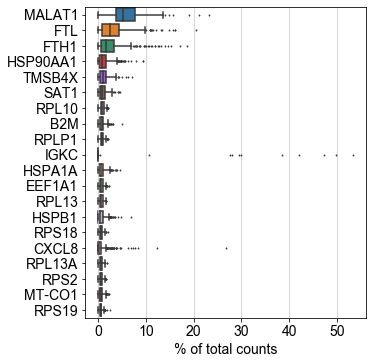

In [4]:
# plot higest expr genes
sc.pl.highest_expr_genes(adata, n_top = 20)

In [5]:
# check if any rows or columns are just zeros
print(np.any(adata.X.sum(axis=0) == 0))
print(np.any(adata.X.sum(axis=1) == 0))

True
False


In [6]:
# keep all cells
sc.pp.filter_cells(adata, min_genes = 0)
# filter genes
sc.pp.filter_genes(adata, min_cells = 3)

filtered out 12270 genes that are detected in less than 3 cells


In [7]:
# perform mitochondria QC
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis = 1) / np.sum(adata.X, axis = 1)
adata.obs['n_counts'] = adata.X.sum(axis = 1)

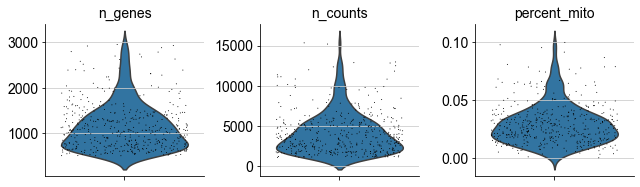

In [8]:
# A violin plot of the computed quality measures.
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter = 0.4, multi_panel = True)

In [9]:
# final filtering
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.5, :]

In [10]:
# creates a copy of the file to hold raw counts
adata_raw = adata
adata_raw

View of AnnData object with n_obs × n_vars = 439 × 12069 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [11]:
# normalize matrix X to 10000 reads per cell
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
# Set the .raw attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. 
adata.raw = adata

In [12]:
# check if any rows or columns are just zeros
print(np.any(adata.X.sum(axis=0) == 0))
print(np.any(adata.X.sum(axis=1) == 0))

True
False


In [13]:
# filter them away from both the raw file and log file
adata_raw = adata_raw[:,adata.X.sum(axis=0) > 0]
adata = adata[:,adata.X.sum(axis=0) > 0]

# save the raw counts as raw_file
adata_raw.write(raw_file)
adata_raw

AnnData object with n_obs × n_vars = 439 × 12068 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

Trying to set attribute `.var` of view, making a copy.


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


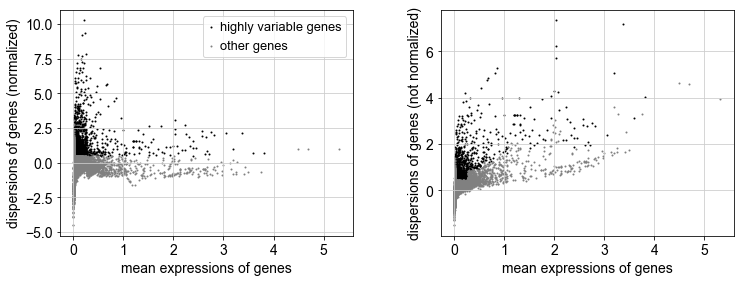

In [14]:
# Identify highly-variable genes.
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 4, min_disp = 0.5)
# plot highly_variable_genes
sc.pl.highly_variable_genes(adata)

In [15]:
# store a copy of the adata for filtering
adata_filter = adata
# Actually do the filtering.
adata_filter = adata_filter[:, adata_filter.var['highly_variable']]

In [16]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
sc.pp.regress_out(adata_filter, ['n_counts', 'percent_mito'])
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata_filter, max_value = 10)

regressing out ['n_counts', 'percent_mito']
    finished (0:00:05.64)


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00.08)


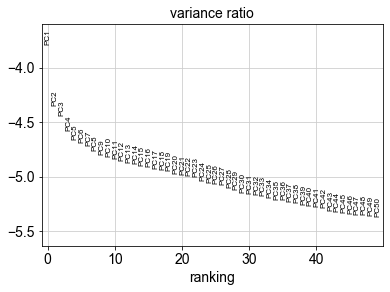

In [17]:
# Principal component analysis
sc.tl.pca(adata_filter, svd_solver = 'arpack')
sc.pl.pca_variance_ratio(adata_filter, log = True, n_pcs = 50)

In [18]:
# Computing the neighborhood graph. Seurat uses k = 20 as default
sc.pp.neighbors(adata_filter, n_neighbors = 10, n_pcs = 30)
# run UMAP
sc.tl.umap(adata_filter, n_components = 2, min_dist = 0.3)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:01.94) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    using 'X_pca' with n_pcs = 30
    finished (0:00:02.06) --> added
    'X_umap', UMAP coordinates (adata.obsm)


In [19]:
# check object
adata_filter

AnnData object with n_obs × n_vars = 439 × 2557 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [20]:
# replace the uns and obsm slots for the original object with the filtered object
adata.uns = adata_filter.uns
adata.obsm = adata_filter.obsm
adata

AnnData object with n_obs × n_vars = 439 × 12068 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca', 'X_umap'

In [21]:
# check if any rows or columns are just zeros
print(np.any(adata.X.sum(axis=0) == 0))
print(np.any(adata.X.sum(axis=1) == 0))

False
False


In [22]:
# scale all the counts
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value = 10)

regressing out ['n_counts', 'percent_mito']
    finished (0:00:21.57)


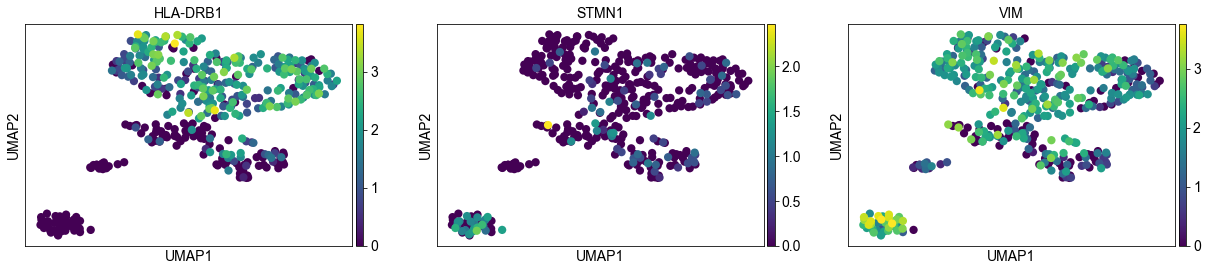

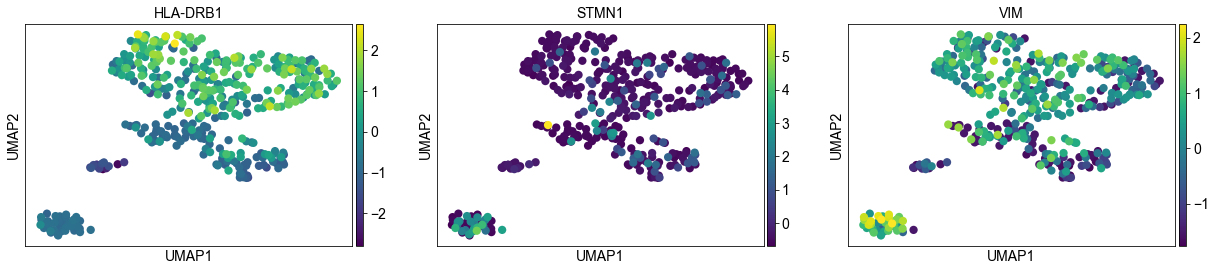

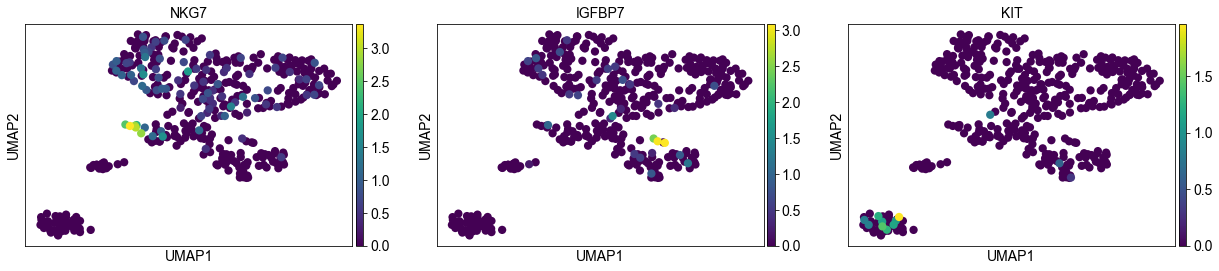

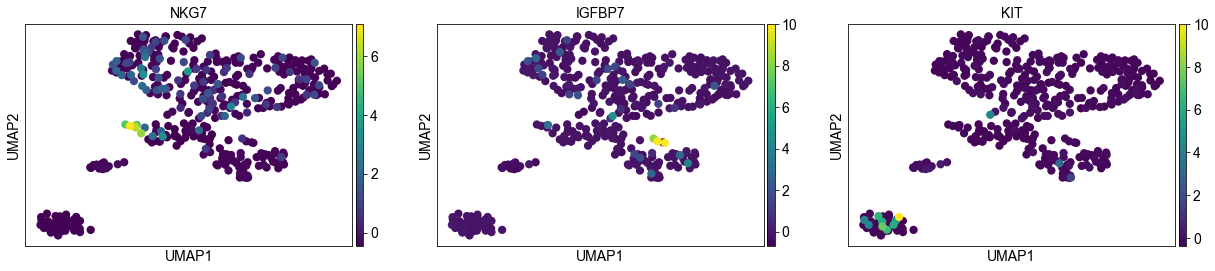

In [23]:
# initial plots
sc.pl.umap(adata, color = ['HLA-DRB1', 'STMN1', 'VIM'])
sc.pl.umap(adata, color = ['HLA-DRB1', 'STMN1', 'VIM'], use_raw = False)
sc.pl.umap(adata, color = ['NKG7', 'IGFBP7', 'KIT'])
sc.pl.umap(adata, color = ['NKG7', 'IGFBP7', 'KIT'], use_raw = False)

running Leiden clustering
    finished (0:00:00.04) --> found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical)


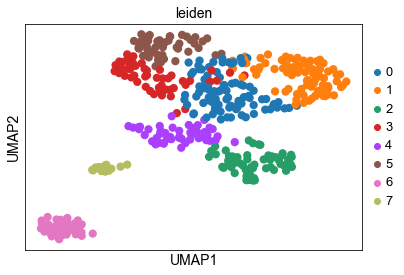

In [24]:
# find clusters
sc.tl.leiden(adata, resolution = 0.8)

# plotting groups and clusters
sc.pl.umap(adata, color = ['leiden'])

ranking genes
    finished (0:00:00.76) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


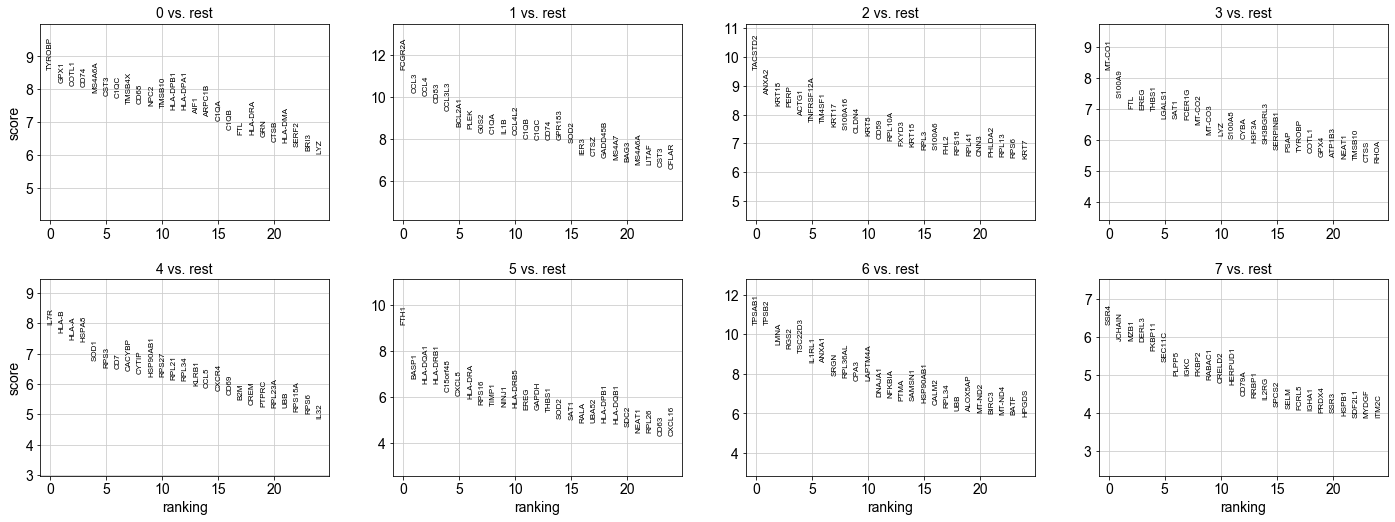

In [25]:
# finding marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [26]:
# save the results file
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 439 × 12068 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'

In [27]:
# # Export clusters
# adata.obs[['leiden']].to_csv('./scanpy/write/henry.immune.leiden.csv')
# # Export embeddings
# adata.obsm[['X_umap']].to_df().to_csv('./scanpy/write/henry.immune.umap.csv')